In [31]:
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from torch.nn.functional import cosine_similarity

-------------------------

In [22]:
# Récupération des données de l'API HAL
url = "https://api.archives-ouvertes.fr/search/"
params = {
    'q': 'labStructAcronym_s:"LIRIS"',  # Recherche par acronyme de laboratoire
    'fl': 'title_s,abstract_s,authFullName_s,producedDateY_i,keyword_s', # Champs à récupérer
    'rows': 10000  # Nombre de résultats à récupérer 10000 pour avoir tous les résultats
}
# Réponse de l'API
reponse = requests.get(url, params=params)
data = reponse.json()

# Récupération des documents
documents = data['response']['docs']

# Remplacement des valeurs manquantes par des chaînes vides
categories = ['title_s', 'abstract_s', 'authFullName_s', 'keyword_s']
for doc in documents:
    for cat in categories:
        if cat not in doc:
            doc[cat] = ['']

# Ecriture des documents dans un json
with open('documents.json', 'w', encoding='utf-8') as f:
    json.dump(documents, f, ensure_ascii=False, indent=4)

In [46]:
# Chargement du modèle
model = SentenceTransformer('all-MiniLM-L6-v2')

# Extraction des informations des documents
informations = [
    f"{doc.get('title_s', '')} "  # Titre
    f"{', '.join(doc.get('keyword_s', []))} "  # Mots-clés
    f"{doc.get('abstract_s', '')} "  # Abstract
    f"Auteurs: {', '.join(doc.get('authFullName_s', []))} "  # Auteurs
    for doc in documents
]

# Générer les embeddings
embeddings = model.encode(informations, convert_to_tensor=True)

# Associer chaque embedding à son document
documents_valides = [doc for doc, titre in zip(documents, informations) if titre.strip()]
documents_embeddings = [
    {"document": doc, "embedding": embedding}
    for doc, embedding in zip(documents_valides, embeddings)
]

8946
{'document': {'title_s': ['Modout: Learning to Fuse Face and Gesture Modalities with Stochastic Regularization'], 'keyword_s': ['Deep learning', 'Gesture recognition'], 'abstract_s': ['Model selection methods based on stochastic regularization such as Dropout have been widely used in deep learning due to their simplicity and effectiveness. The standard Dropout method treats all units, visible or hidden, in the same way, thus ignoring any \\emph{a priori} information related to grouping or structure. Such structure is present in multi-modal learning applications such as affect analysis and gesture recognition, where subsets of units may correspond to individual modalities. In this paper we describe Modout, a model selection method based on stochastic regularization, which is particularly useful in the multi-modal setting. Different from previous methods, it is capable of learning whether or when to fuse two modalities in a layer, which is usually considered to be an architectural h

In [71]:
def recherche_semantique(query, embeddings, documents, model):
    # Générer l'embedding pour la requête utilisateur
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Calculer la similarité cosinus entre la requête et chaque document
    similarites = cosine_similarity(query_embedding, embeddings)

    # Trouver les indices des documents les plus pertinents
    indices_tries = similarites.argsort(descending=True)

    # Retourner les documents triés par pertinence
    resultats = [documents[i] for i in indices_tries[:5]]
    return resultats

# Exemple de requête
query = "Cedric chauve"
resultats = recherche_semantique(query, embeddings, documents_valides, model)

# Afficher les résultats
for res in resultats:
    print(f"Titre: {res['title_s']}, Mot-clés: {res['keyword_s']}), Auteurs: {res['authFullName_s']}")

Titre: ['In Response to Scholz et al.'], Mot-clés: ['']), Auteurs: ['Michael Beuve', 'C. Rodriguez-Lafrasse']
Titre: ["Modélisation d'Organes en Mouvement, Etude des Paramètres Mécaniques"], Mot-clés: ['']), Auteurs: ['Pierre-Frédéric Villard', 'Vincent Baudet', 'Michaël Beuve', 'Fabrice Jaillet', 'B. Shariat']
Titre: ['Translucidité : pour y voir plus clair.'], Mot-clés: ['']), Auteurs: ['Lionel Simonot', 'Morgane Gérardin', 'Mathieu Hébert', 'Thierry Fournel', 'Jean-Philippe Farrugia', 'Jean-Claude Iehl']
Titre: ['Décision distribuée'], Mot-clés: ['']), Auteurs: ['Stéphane Bonnevay', 'Nadia Kabachi', 'Michel Lamure']
Titre: ['Etude de mouvement dans une acquisition tomodensitométrique 4D par recalage déformable'], Mot-clés: ['']), Auteurs: ['Vlad Boldea', 'David Sarrut', 'Gregory C. Sharp', 'Steve B. Jiang', 'Noah C. Choi']


In [10]:
# Chercher si un auteur a publié plusieurs fois (pour mieux visualiser dans le graphe après)
authors = {}
for doc in data['response']['docs']:
    for author in doc['authFullName_s']:
        if author in authors:
            authors[author] += 1
        else:
            authors[author] = 1
            
for author, count in authors.items():
    if count > 1:
        print(f"{author} a publié {count} fois")

Guillaume Lavoué a publié 3 fois
Florent Dupont a publié 3 fois
Atilla Baskurt a publié 3 fois


In [11]:
G2 = nx.Graph()
# Création des noeuds et des arêtes
for pub in data['response']['docs']:
    # Création du noeud article
    title = pub.get('title_s')[0]
    year = pub['producedDateY_i']
    article_node = f"Article: {title} ({year})"
    G2.add_node(article_node, type='article', year=year)
    
    # Création des noeuds auteurs et des arêtes qui relient les auteurs à l'article
    authors = pub.get('authFullName_s', [])
    for author in authors:
        author_node = f"Auteur: {author}"
        G2.add_node(author_node, type='auteur')
        G2.add_edge(article_node, author_node, relation='WRITTEN_BY')
    
    # Création des noeuds mots-clés et des arêtes qui relient les mots-clés à l'article
    keywords = pub.get('keyword_s', [])
    for keyword in keywords:
        keyword_node = f"Mot-clé: {keyword}"
        G2.add_node(keyword_node, type='mot-clé')
        G2.add_edge(article_node, keyword_node, relation='HAS_KEYWORD')
        

In [12]:
print('Nombre de noeuds:', G2.number_of_nodes())

Nombre de noeuds: 45


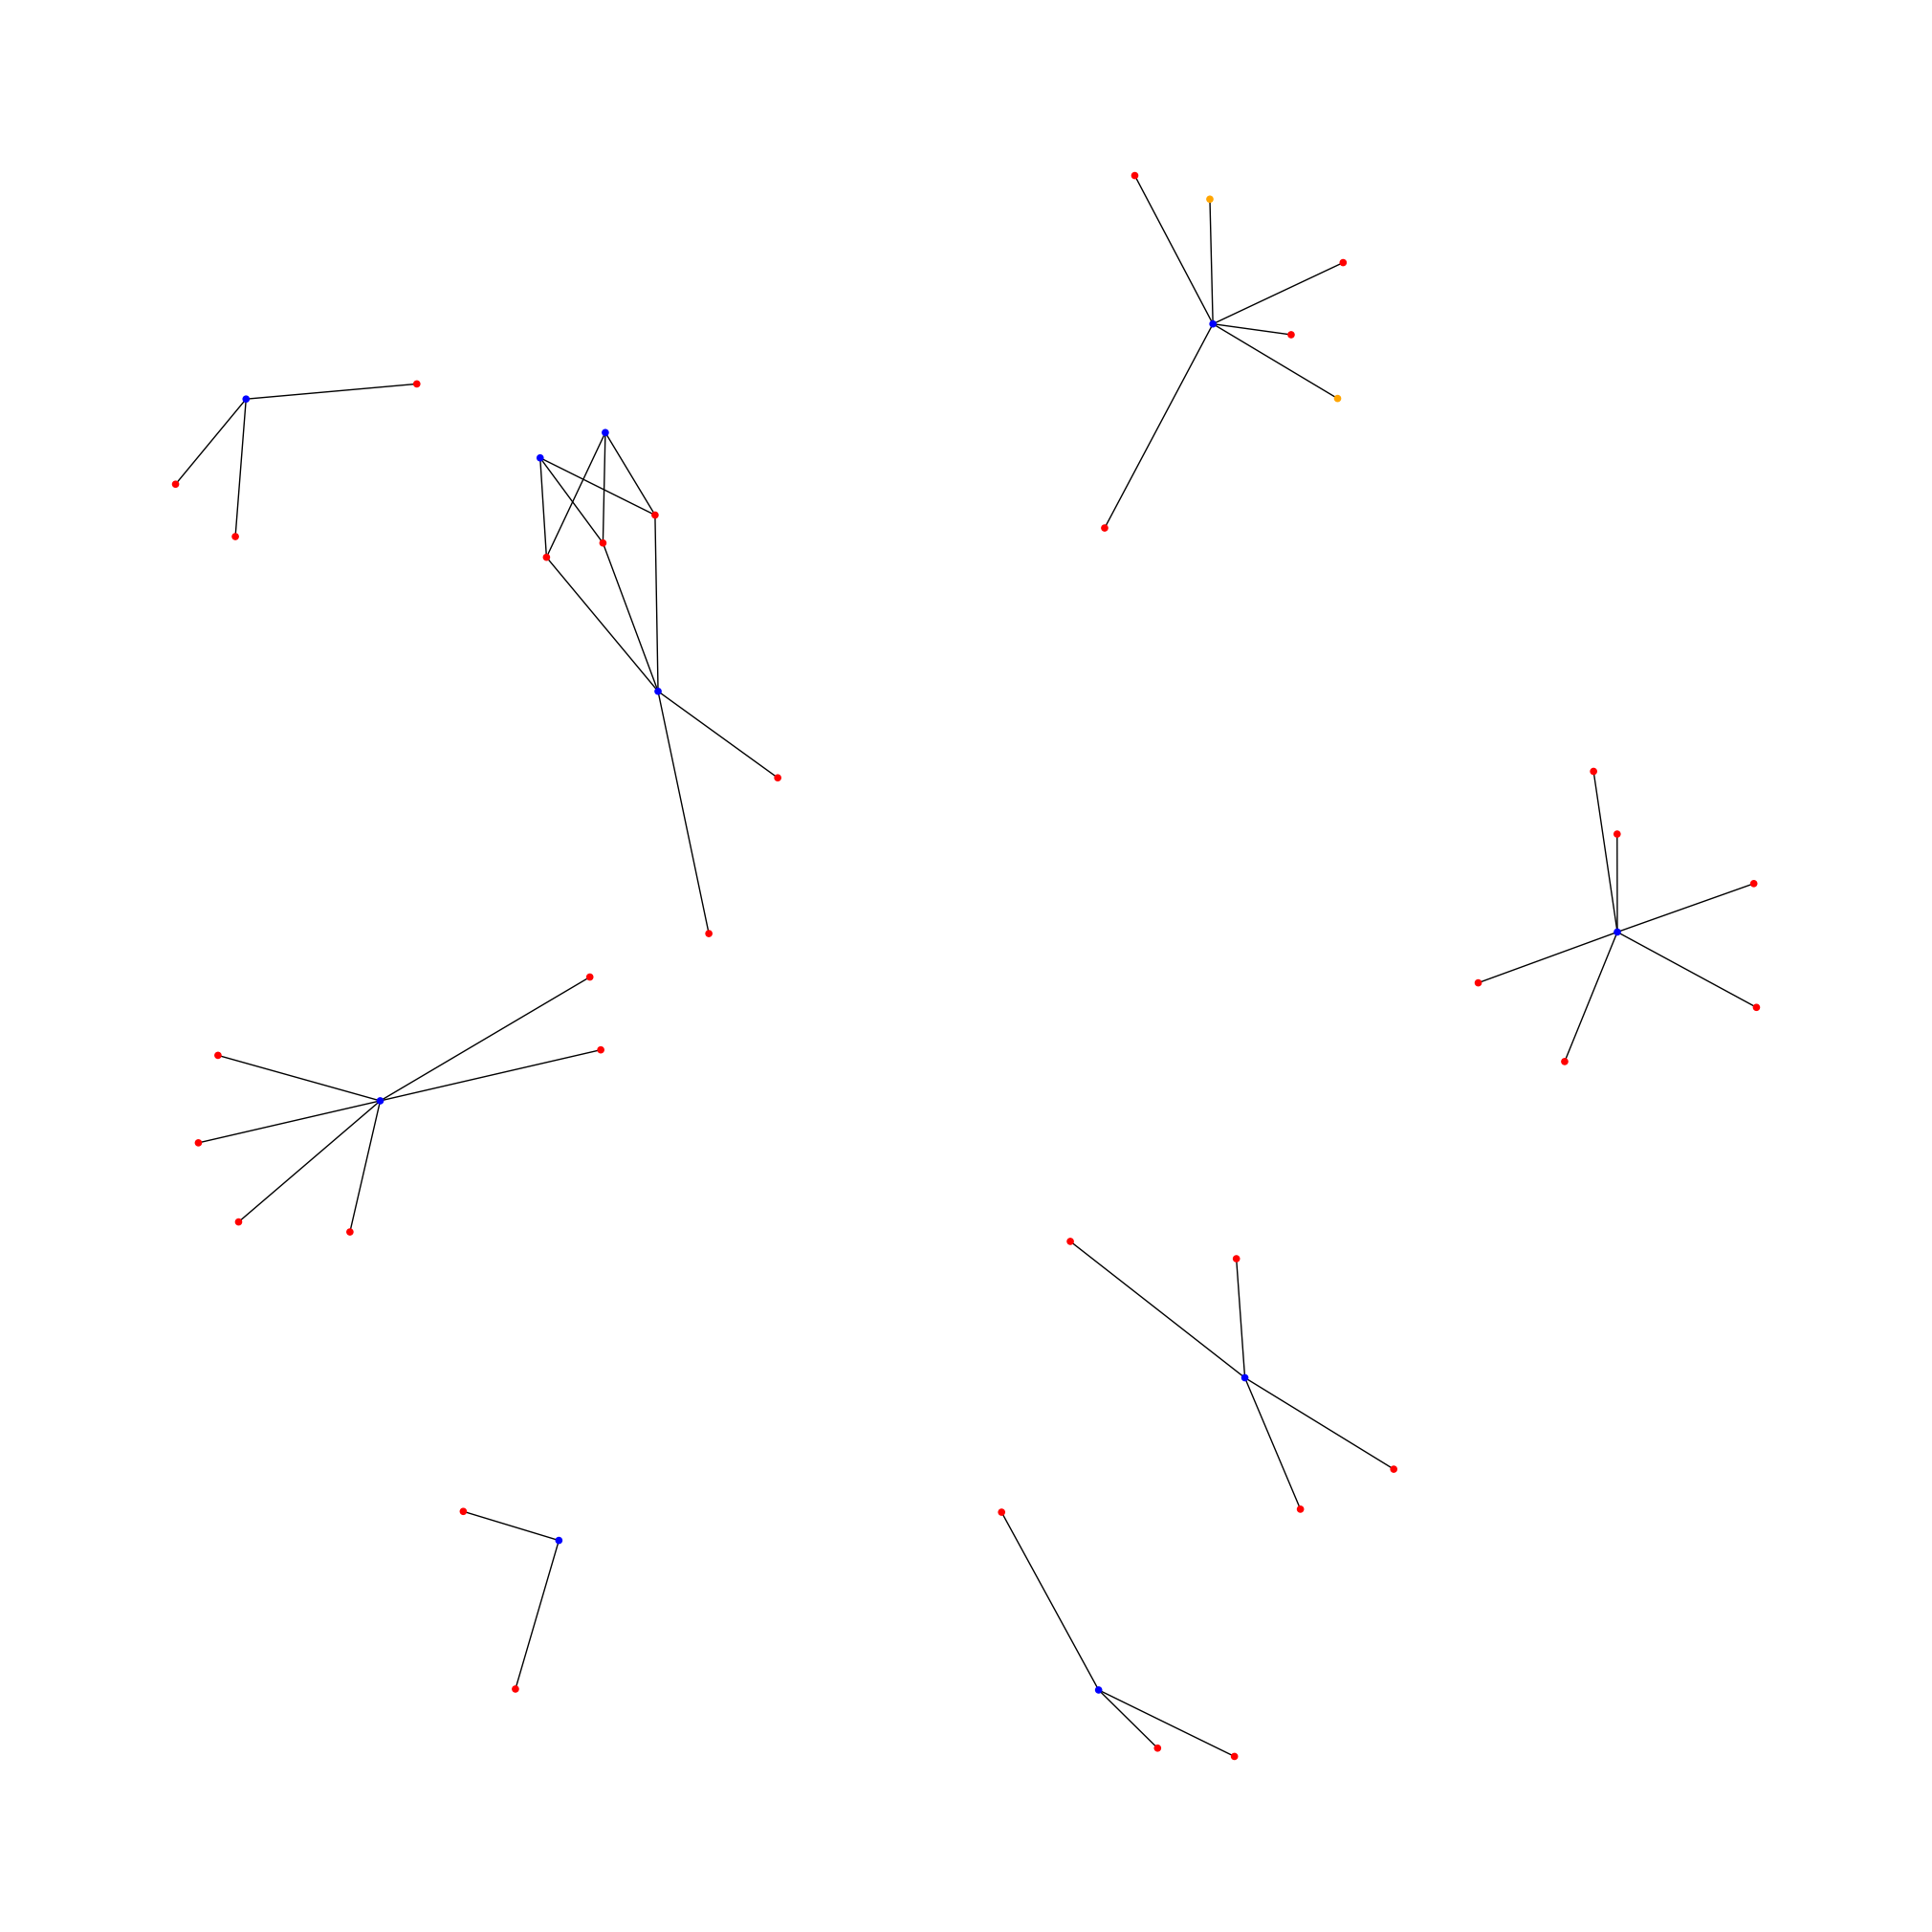

In [13]:
# Visualisation du graphe
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G2, k=0.3)
node_colors = ["blue" if G2.nodes[n]["type"] == "article" 
                   else "red" if G2.nodes[n]["type"] == "auteur" 
                   else "orange" for n in G2.nodes()]
nx.draw(G2, pos, node_size=20, with_labels=False, node_color=node_colors)